# Introduction and Dataset

## Background

Add bg

## Tutorial goals

**Goal 1: Train a semantic segmentation convolutional neural network (CNN) to classify tree species across the PRF using the 2018 Sentinel-2 imagery.**

**Goal 2: Apply the trained CNN for inference to the 2024 Sentinel-2 imagery**  

**Goal 3: Evaluate the species change differences between the two time periods. Discuss and explain changes and differences**

## Data

This tutorial makes use of Sentinel-2 multispectral imagery. See the README or website for more information about the Sentinel-2 dataset.

## References

- [Excellent github repo with many deep learning applications to satellite imagery](https://github.com/satellite-image-deep-learning/techniques)


Add export of unsupervised classified imagery for tutorial

In [1]:
import rioxarray as rio
from rasterio.plot import show
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box as shapely_box
from matplotlib import pyplot as plt

In [2]:
# Helper functions

def simplify_plt(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

def plot_rgb(rgb, ax, low_perc=1, high_perc=99):

    #find the values to do contrast stretching
    vmin, vmax = np.nanpercentile(rgb, (low_perc, high_perc))

    #ensure values are between 0 and 1
    rgb = np.clip(rgb, vmin, vmax)

    # Visualize the PRF Sentinel-2 imagery
    show(rgb, ax=ax, adjust=True)

In [3]:
# Load sentinel-2 imagery

s2_2018_fpath = 'data/petawawa_s2_2018.tif'

s2_2018 = rio.open_rasterio(s2_2018_fpath)

s2_2018

<xarray.DataArray (band: 12, y: 937, x: 1824)> Size: 82MB
[20509056 values with dtype=float32]
Coordinates:
  * band         (band) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 15kB 2.973e+05 2.973e+05 ... 3.155e+05 3.155e+05
  * y            (y) float64 7kB 5.099e+06 5.099e+06 ... 5.089e+06 5.089e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        0.070000000298023
    STATISTICS_MEAN:           0.018834212006213
    STATISTICS_MINIMUM:        0.0082999998703599
    STATISTICS_STDDEV:         0.0052944059050194
    STATISTICS_VALID_PERCENT:  99.9
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8...

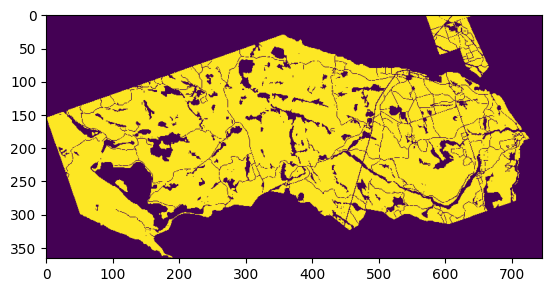

<Axes: >

In [8]:
# Load 95th height percentile to delineate forest and non-forest area
als_metrics = rio.open_rasterio(r'data/als_metrics.tif')

p95_ras = als_metrics.sel(band=1)

# We are only interested in areas that are forested, and more than 1m in height
forest_mask = p95_ras > 1

show(forest_mask)

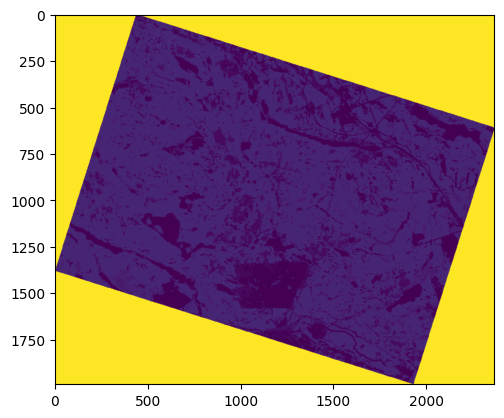

<Axes: >

In [5]:
# Load tree species raster

sp_ras = rio.open_rasterio('data/prf_tree_species_ntems.tif')

show(sp_ras.values)

<xarray.DataArray (y: 366, x: 746)> Size: 273kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(366, 746))
Coordinates:
    band         int64 8B 1
  * x            (x) float64 6kB 2.974e+05 2.974e+05 ... 3.16e+05 3.16e+05
  * y            (y) float64 3kB 5.099e+06 5.099e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0

In [ ]:
# Clip both rasters to the forested area
s2_2018.values[0].shape

p95_ras



(366, 746)

In [ ]:
sp_codes_fpath = r'data/ntems_lead_sp_codes.csv'

sp_code_df = (pd.read_csv(sp_codes_fpath)
              .rename(columns={'Class': 'sp_code',
                               'Common name': 'species'})
              )

sp_code_df

In [ ]:
# Check sp frequency
sp_counts = np.unique(sp_ras.values, return_counts=True)

sp_df = pd.DataFrame({'species': sp_counts[0], 
                            'count': sp_counts[1]})

sp_df['perc'] = round(sp_df['count'] / sp_df['count'].sum() * 100, 1)

sp_df = (sp_df
 .sort_values('count', ascending=False)
 .reset_index(drop=True)
 .rename(columns={'species': 'sp_code'})
 .merge(sp_code_df, on='sp_code', how='inner')
 )

sp_df

In [ ]:
# Check that both rasters have the same CRS and resolution
assert s2_2018.rio.crs == sp_ras.rio.crs, "CRS mismatch between Sentinel-2 and species raster"
assert s2_2018.rio.resolution() == sp_ras.rio.resolution(), "Resolution mismatch between Sentinel-2 and species raster"

In [ ]:
# Get bounds of the rasters
s2_bounds = s2_2018.rio.bounds()
s2_bounds

x_center = (s2_bounds[0] + s2_bounds[2]) / 2
y_center = (s2_bounds[1] + s2_bounds[3]) / 2

# Create a box using center coordinates and a buffer
buffer = 2000 
box = [x_center - buffer, y_center - buffer, x_center + buffer, y_center + buffer]

# Convert to geopandas GeoSeries for clipping
box = shapely_box(*box)

# Clip the species raster to the box
sp_ras_clipped = sp_ras.rio.clip_box(*box.bounds)

# Clip the Sentinel-2 imagery to the same box
s2_2018_clipped = s2_2018.rio.clip_box(*box.bounds)



# show(sp_ras_clipped.values, cmap='Set1')

# Make side by side plots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the clipped Sentinel-2 imagery
plot_rgb(s2_2018_clipped.values[1:4], ax=ax[0])
ax[0].set_title('Sentinel-2 Imagery (2018)')

show(sp_ras_clipped.values, ax=ax[1], cmap='Set1')
ax[1].set_title('Tree Species Raster (2018)')

for a in ax:
    simplify_plt(a)

In [ ]:
# Use a UNet model
import torch
import torchvision.models.segmentation as models

num_classes = 2 

model = models.deeplabv3_resnet50(pretrained=True)

model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

model